In [1]:
import argparse
import math
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import time
import random
import torch.nn.functional as F
from model_utility import *
from dataset_utility import *
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from cka_utility import *
# from seaborn import heatmap

from config import Config
from models import *

import numpy as np
from plot import *
parser = argparse.ArgumentParser(description='FQ-ViT')

parser.add_argument('--model',
                    choices=[
                        'deit_tiny', 'deit_small', 'deit_base', 'vit_base',
                        'vit_large', 'swin_tiny', 'swin_small', 'swin_base'
                    ],
                    default='deit_tiny',
                    help='model')
parser.add_argument('--data', metavar='DIR',
                    default='/home/ubuntu/imagenet',
                    help='path to dataset')
parser.add_argument('--quant', default=True, action='store_true')
parser.add_argument('--ptf', default=False)
parser.add_argument('--lis', default=False)
parser.add_argument('--quant-method',
                    default='minmax',
                    choices=['minmax', 'ema', 'omse', 'percentile'])
parser.add_argument('--mixed', default=True, action='store_true')
# TODO: 100 --> 32
parser.add_argument('--calib-batchsize',
                    default=50,
                    type=int,
                    help='batchsize of calibration set')
parser.add_argument("--mode", default=0,
                        type=int, 
                        help="mode of calibration data, 0: PSAQ-ViT, 1: Gaussian noise, 2: Real data")
# TODO: 10 --> 1
parser.add_argument('--calib-iter', default=10, type=int)
# TODO: 100 --> 200
parser.add_argument('--val-batchsize',
                    default=200,
                    type=int,
                    help='batchsize of validation set')
parser.add_argument('--num-workers',
                    default=16,
                    type=int,
                    help='number of data loading workers (default: 16)')
parser.add_argument('--device', default='cuda', type=str, help='device')
parser.add_argument('--print-freq',
                    default=100,
                    type=int,
                    help='print frequency')
parser.add_argument('--seed', default=0, type=int, help='seed')


args = parser.parse_args(args=[])
seed(args.seed)

device = torch.device(args.device)
cfg = Config(args.ptf, args.lis, args.quant_method)
# model = str2model(args.model)(pretrained=True, cfg=cfg)
# model = model.to(device)



# Note: Different models have different strategies of data preprocessing.
model_type = args.model.split('_')[0]
if model_type == 'deit':
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    crop_pct = 0.875
elif model_type == 'vit':
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    crop_pct = 0.9
elif model_type == 'swin':
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    crop_pct = 0.9
else:
    raise NotImplementedError
train_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)
val_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)

# Data
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

val_dataset = datasets.ImageFolder(valdir, val_transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=args.val_batchsize,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
)
# switch to evaluate mode
# model.eval()

# define loss function (criterion)
criterion = nn.MSELoss().to(device)

train_dataset = datasets.ImageFolder(traindir, train_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.calib_batchsize,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True,
)

/opt/conda/envs/diffvit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/diffvit/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [2]:
# int8_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)
int4_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)
not_quantized_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)

# restore_indices = [8, 19]

# eight_bit_config = [8]*50
#basic_net, epsilon, step_size, num_steps, bit_config, args
not_quantized_attack_net = AttackPGD(
    basic_net=not_quantized_model, 
    epsilon=0.06,
    step_size=0.01,
    num_steps=50,
    bit_config=None,
    args=args)

four_bit_config = [4]*50


# seed_images, seed_labels = not_quantized_attack_net.get_seed_inputs(5, rand=False)
# adv_inputs = not_quantized_attack_net.gen_adv_inputs(seed_images, seed_labels)

# int8_model = calibrate_model(args.mode, args, int8_model, train_loader, device)
# int4_model = calibrate_model(args.mode, args, int4_model, train_loader, device)


# int8_model.eval()
# int4_model.eval()
# not_quantized_model.eval()

print()

Model: deit_tiny_patch16_224
Model: deit_tiny_patch16_224



In [6]:
# from pyhessian import hessian

# # # TODO:
# # #####################################################
# print("Calculating the sensitiveties via the averaged Hessian trace.......")
# batch_num = 10
# trace_list = []
# criterion = nn.CrossEntropyLoss().to(device)
# for i, (inputs, labels) in enumerate(train_loader):
#     hessian_comp = hessian(not_quantized_model,
#                     criterion,
#                     data=(inputs, labels),
#                     cuda=args.device)
#     print("현재 몇번쨰?", i)
#     name, trace = hessian_comp.trace()
#     trace_list.append(trace)
#     if i == batch_num - 1:
#         break

# # top_eigenvalues, _ = hessian_comp.eigenvalues()
# # trace = hessian_comp.trace()
# # density_eigen, density_weight = hessian_comp.density()
# # print('\n***Top Eigenvalues: ', top_eigenvalues)

# new_global_hessian_track = []
# for i in range(int(len(trace_list))):
#     hessian_track = trace_list[i]
#     hessian_track = [abs(x) for x in hessian_track]
#     min_h = min(hessian_track)
#     max_h = max(hessian_track)
#     averaged_hessian_track = [(elem-min_h)/(max_h-min_h) for elem in hessian_track]
#     new_global_hessian_track.append(averaged_hessian_track)


# # min_hessian = []
# # max_hessian = []
# mean_hessian = []
# layer_num = len(trace_list[0])
# for i in range(layer_num):
#     new_hessian = [sample[i] for sample in new_global_hessian_track]
#     mean_hessian.append(sum(new_hessian)/len(new_hessian))
#     # min_hessian.append(min(new_hessian))
#     # max_hessian.append(max(new_hessian))

# print(name)
# print('\n***Trace: ', mean_hessian)

Calculating the sensitiveties via the averaged Hessian trace.......


/opt/conda/envs/diffvit/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/envs/diffvit/lib/python3.9/site-packages/torch/autograd/graph.py:769: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1

현재 몇번쨰? 0
현재 몇번쨰? 1
현재 몇번쨰? 2
현재 몇번쨰? 3
현재 몇번쨰? 4
현재 몇번쨰? 5
현재 몇번쨰? 6
현재 몇번쨰? 7
현재 몇번쨰? 8
현재 몇번쨰? 9
['blocks.0.attn.qkv.weight', 'blocks.0.attn.proj.weight', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc2.weight', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.proj.weight', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc2.weight', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.proj.weight', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc2.weight', 'blocks.3.attn.qkv.weight', 'blocks.3.attn.proj.weight', 'blocks.3.mlp.fc1.weight', 'blocks.3.mlp.fc2.weight', 'blocks.4.attn.qkv.weight', 'blocks.4.attn.proj.weight', 'blocks.4.mlp.fc1.weight', 'blocks.4.mlp.fc2.weight', 'blocks.5.attn.qkv.weight', 'blocks.5.attn.proj.weight', 'blocks.5.mlp.fc1.weight', 'blocks.5.mlp.fc2.weight', 'blocks.6.attn.qkv.weight', 'blocks.6.attn.proj.weight', 'blocks.6.mlp.fc1.weight', 'blocks.6.mlp.fc2.weight', 'blocks.7.attn.qkv.weight', 'blocks.7.attn.proj.weight', 'blocks.7.mlp.fc1.weight', 'blocks.7.mlp.fc2.weight', 'blocks.8.a

In [3]:
from pyhessian import DDVHessian
        
# # TODO:
# #####################################################
print("Calculating the sensitiveties via the averaged Hessian trace.......")
batch_num = 10
trace_list = []
not_quantized_model.eval()
for i, (inputs, labels) in enumerate(train_loader):
    adv_inputs = not_quantized_attack_net.gen_adv_inputs(inputs, labels)
        
        
    inputs, targets = inputs.cuda(), labels.cuda()

    # if we only compute the Hessian information for a single batch data, we can re-use the gradients.
    normal_outputs, _, _ = not_quantized_model(inputs,  hessian_statistic=True)
    adv_outputs, _, _ = not_quantized_model(adv_inputs, hessian_statistic=True)
    original_ddv = torch.matmul(normal_outputs, adv_outputs.t())
    original_ddv = original_ddv.detach()
    
    hessian_comp = DDVHessian(
                    model = not_quantized_model,
                    q_model= int4_model,
                    criterion= torch.nn.MSELoss(),
                    data=(inputs, labels),
                    adv_data=(adv_inputs, labels),
                    original_ddv=original_ddv,
                    attack_net=not_quantized_attack_net,
                    cuda=args.device)
    print("현재 몇번쨰?", i)
    # for grad in hessian_comp.gradsH:
    #     print(grad.cpu().detach().numpy().sum())
    name, trace = hessian_comp.trace()
    trace_list.append(trace)
    if i == batch_num - 1:
        break

# top_eigenvalues, _ = hessian_comp.eigenvalues()
# trace = hessian_comp.trace()
# density_eigen, density_weight = hessian_comp.density()
# print('\n***Top Eigenvalues: ', top_eigenvalues)

new_global_hessian_track = []
for i in range(int(len(trace_list))):
    hessian_track = trace_list[i]
    hessian_track = [abs(x) for x in hessian_track]
    min_h = min(hessian_track)
    max_h = max(hessian_track)
    averaged_hessian_track = [(elem-min_h)/(max_h-min_h) for elem in hessian_track]
    new_global_hessian_track.append(averaged_hessian_track)


# min_hessian = []
# max_hessian = []
layer_num = len(trace_list[0])


Calculating the sensitiveties via the averaged Hessian trace.......


/opt/conda/envs/diffvit/lib/python3.9/site-packages/torch/autograd/graph.py:769: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1203.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


현재 몇번쨰? 0
현재 몇번쨰? 1
현재 몇번쨰? 2
현재 몇번쨰? 3
현재 몇번쨰? 4
현재 몇번쨰? 5
현재 몇번쨰? 6
현재 몇번쨰? 7
현재 몇번쨰? 8
현재 몇번쨰? 9


In [7]:
# mean_hessian = []

# for i in range(layer_num):
#     new_hessian = [sample[i] for sample in new_global_hessian_track]
#     mean_hessian.append(sum(new_hessian)/len(new_hessian))
#     # min_hessian.append(min(new_hessian))
#     # max_hessian.append(max(new_hessian))

# print(name)
# print('\n***Trace: ', mean_hessian)

['blocks.0.attn.qkv.weight', 'blocks.0.attn.proj.weight', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc2.weight', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.proj.weight', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc2.weight', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.proj.weight', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc2.weight', 'blocks.3.attn.qkv.weight', 'blocks.3.attn.proj.weight', 'blocks.3.mlp.fc1.weight', 'blocks.3.mlp.fc2.weight', 'blocks.4.attn.qkv.weight', 'blocks.4.attn.proj.weight', 'blocks.4.mlp.fc1.weight', 'blocks.4.mlp.fc2.weight', 'blocks.5.attn.qkv.weight', 'blocks.5.attn.proj.weight', 'blocks.5.mlp.fc1.weight', 'blocks.5.mlp.fc2.weight', 'blocks.6.attn.qkv.weight', 'blocks.6.attn.proj.weight', 'blocks.6.mlp.fc1.weight', 'blocks.6.mlp.fc2.weight', 'blocks.7.attn.qkv.weight', 'blocks.7.attn.proj.weight', 'blocks.7.mlp.fc1.weight', 'blocks.7.mlp.fc2.weight', 'blocks.8.attn.qkv.weight', 'blocks.8.attn.proj.weight', 'blocks.8.mlp.fc1.weight', 'blocks.8.mlp.fc2.weight', 

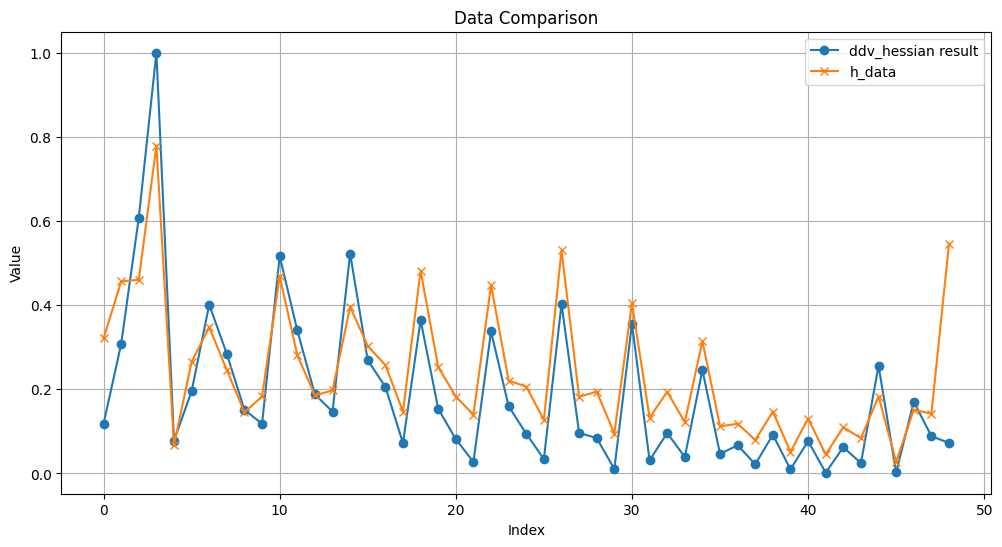

In [7]:
import numpy as np
import matplotlib.pyplot as plt
#ddv_hessian result
dh_data = [np.float64(0.1177874175069632), np.float64(0.3079008025314483), np.float64(0.6075554958688494), np.float64(1.0), np.float64(0.07821698416178048), np.float64(0.1955333071350255), np.float64(0.40127888402467055), np.float64(0.2838752739699172), np.float64(0.15095418877352407), np.float64(0.11820856377039632), np.float64(0.5166406866489658), np.float64(0.3399695649379112), np.float64(0.18781069030442923), np.float64(0.14687531772298695), np.float64(0.5226089516998274), np.float64(0.2689235259895636), np.float64(0.2060400941362838), np.float64(0.07209597790178655), np.float64(0.36436740955400165), np.float64(0.15389476896718252), np.float64(0.08123767133111293), np.float64(0.02751944648340926), np.float64(0.33751809608920463), np.float64(0.1596040988564092), np.float64(0.09439314566049087), np.float64(0.034284100699447435), np.float64(0.4028230468862494), np.float64(0.09627690304628482), np.float64(0.08412462954368802), np.float64(0.01046318222522866), np.float64(0.35576731244314375), np.float64(0.031088263868576937), np.float64(0.09626862791441057), np.float64(0.0390631356320333), np.float64(0.24585765421708672), np.float64(0.04642565503028732), np.float64(0.06702515322052251), np.float64(0.021899440386072284), np.float64(0.09214246551855504), np.float64(0.009694668797114402), np.float64(0.0770983640089043), np.float64(0.001766119927937541), np.float64(0.062463411873129246), np.float64(0.024433206593464624), np.float64(0.2560165376620039), np.float64(0.0024940805060462813), np.float64(0.1706602951599041), np.float64(0.08863532085132826), np.float64(0.07255832024490312)]
# 데이터
h_data =  [np.float64(0.32094153253371516), np.float64(0.45630186701573505), np.float64(0.46027244507048987), np.float64(0.778837614484494), np.float64(0.06803271888263146), np.float64(0.2651026572969264), np.float64(0.34762614370520195), np.float64(0.24576950173524778), np.float64(0.14522478811562511), np.float64(0.183265473436163), np.float64(0.4685355166353071), np.float64(0.28116584401638656), np.float64(0.18557367633130858), np.float64(0.19741098361054094), np.float64(0.3959751448411542), np.float64(0.30273725553180786), np.float64(0.2577341367269725), np.float64(0.14692009599275385), np.float64(0.4818070642016027), np.float64(0.25307655947561186), np.float64(0.18264605495607716), np.float64(0.1398189088036304), np.float64(0.4474852839027186), np.float64(0.2208056464760657), np.float64(0.2061968499447587), np.float64(0.1273108228158563), np.float64(0.530220292330312), np.float64(0.1822870738218118), np.float64(0.19431540297348476), np.float64(0.0948252594015712), np.float64(0.4049385154233212), np.float64(0.13258631555810402), np.float64(0.19401667197636482), np.float64(0.12192959061979511), np.float64(0.3148483680683384), np.float64(0.1120782487706864), np.float64(0.11810479281312165), np.float64(0.07956094672606405), np.float64(0.14698189904828382), np.float64(0.0514896730694905), np.float64(0.13057197621385722), np.float64(0.04516762398039), np.float64(0.10971315247471905), np.float64(0.08390269269160204), np.float64(0.1829256614692566), np.float64(0.02761632079446335), np.float64(0.15136467748834015), np.float64(0.1419573449597424), np.float64(0.5461621842825806)]



# numpy 배열로 변환
y1 = np.array(dh_data)
y2 = np.array(h_data)

# x 축 값 생성 (0부터 데이터 길이까지)
x = np.arange(len(y1))

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(x, y1, marker='o', label='ddv_hessian result')
plt.plot(x, y2, marker='x', label='h_data')
plt.title('Data Comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()  # 범례 추가
plt.grid(True)

# 그래프 표시
plt.show()


In [ ]:
# Usage example
print("Calculating the sensitivities via the averaged Hessian trace...")
batch_num = 10
trace_list = []
not_quantized_model.eval()
for i, (inputs, labels) in enumerate(train_loader):
    adv_inputs = not_quantized_attack_net.gen_adv_inputs(inputs, labels)
    inputs, targets = inputs.cuda(), labels.cuda()

    # Initialize the DDVHessian class with data for each batch
    hessian_comp = DDVHessian(
        model=not_quantized_model,
        q_model=int4_model,
        criterion=torch.nn.MSELoss(),
        data=(inputs, labels),
        adv_data=(adv_inputs, labels),
        attack_net=not_quantized_attack_net,
        cuda=args.device
    )
    print(f"Processing batch {i + 1}/{batch_num}")
    name, trace = hessian_comp.trace()
    trace_list.append(trace)
    if i == batch_num - 1:
        break

# Process the trace_list as needed